In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys  
sys.path.insert(1, '/home/marguerite/Documents/lab/TrajoptMPCReference')
import overloading

In [160]:
trace_ID_1 = 1 # 1, 1.5
trace_ID_2 = 2 # -1, -1.5
trace_ID_3 = 3 # -1.18, -1.58, #bad

# 4 good

In [161]:
def read_trace(id):
    file_path = f'../data/{id}/trace.plk'
    df = pd.read_pickle(file_path)
    return df

# trace_1=read_trace(trace_ID_1)
# trace_2=read_trace(trace_ID_2)
trace_3=read_trace(trace_ID_3)
trace_4=read_trace(4)


In [162]:
def plot_main_trace(df):
    plt.figure(figsize=(5, 2))
    df.plot(x='iteration', y=['J', 'merit', 'reduction_ratio'], kind='line')
    plt.xticks(df['iteration']) 
    plt.show()

<Figure size 500x200 with 0 Axes>

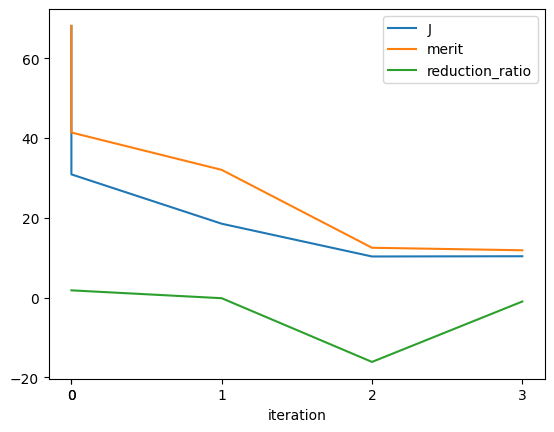

<Figure size 500x200 with 0 Axes>

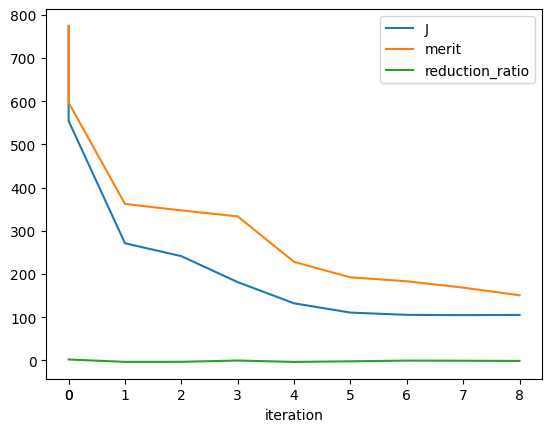

In [163]:
plot_main_trace(trace_4)
plot_main_trace(trace_3)


Plot the error at each iteration

In [164]:
def get_dx_from_file(id):
    df = pd.read_pickle(f'../data/{id}/dx.plk')
    df['dx']=df['value'].apply(lambda x: np.abs(x[0]))
    df['dy']=df['value'].apply(lambda x: np.abs(x[1]))
    df['vx']=df['value'].apply(lambda x: np.abs(x[2]))
    df['vy']=df['value'].apply(lambda x: np.abs(x[3]))
    df['norm']=np.sqrt(df['dx']**2 + df['dy']**2 + df['vx']**2  + df['vy']**2 )
    df=df.drop(columns=['value'])

    return df

def plot_error(df):
    # fig, ax1 = plt.subplots(figsize=(10, 5))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [4, 1]})
    ax1.plot(df['dx'], marker='o', linestyle='-', color='green')
    ax1.grid(True)
    ax1.set_ylabel('error', color='black')
    ax1.set_title('Norm of the end effector error over time')
    ax1.set_xticklabels([])

    ax2.plot(df['iteration'], linestyle='-', color='black', label='QP Iteration', linewidth=0.8)
    ax2.set_ylabel('SQP Iteration', color='black')
    ax2.set_xticklabels([])
    ax2.plot(df['line_search_iteration'], linestyle='-', color='purple', label='Line search Iteration', linewidth=0.8)

    ax2.set_ylim([0,9])
    fig.legend(loc='lower right', bbox_to_anchor=(1, 1), bbox_transform=ax2.transAxes)

    unique_iterations = df['iteration'].unique()

    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_iterations)))

    for i, iteration in enumerate(unique_iterations):
        mask = df['iteration'] == iteration
        ax1.axvspan(df.index[mask].min(), df.index[mask].max(), color=colors[i], alpha=0.3)
    plt.show()

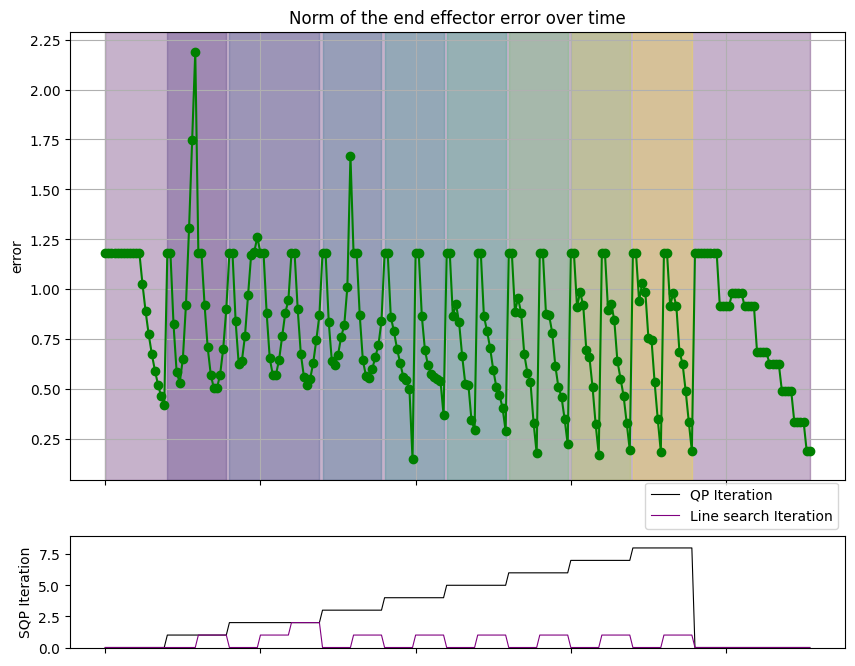

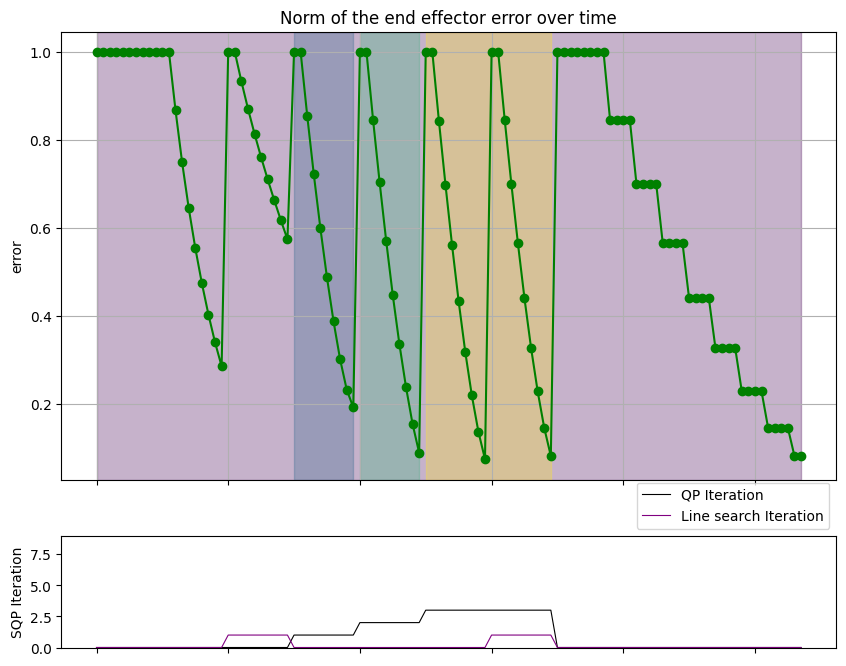

In [172]:
error = get_dx_from_file(trace_ID_3)
plot_error(error)
error = get_dx_from_file(4)
plot_error(error)

### Inner traces

In [167]:
def get_inner_traces_from_file(id):
    df = pd.read_pickle(f'../data/{id}/inner_traces.plk')
    df['Iteration']=df[1]
    df['Outer Iteration']=df[2]
    df['r']=df[0].apply(lambda x: x[0])
    df['error']=df[0].apply(lambda x: x[1])
    df['PCG_iteration']=df['r'].apply(lambda x: len(x))
    df=df.drop(columns=[0,1,2])
    return df

def plot_inner_trace(df, iteration):
    plt.figure(figsize=(10, 5))
    trace=df[df['Iteration']==iteration]
    r=trace['r'].values[0]
    error=trace['error'].values[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(r, marker='o', linestyle='-', color='green')
    ax1.set_title('residual: b-Ax')
    ax1.grid(True)

    ax2.plot(error, marker='o', linestyle='-', color='red')
    ax2.set_title('Error')
    ax2.grid(True)

    fig.suptitle(f'Inner Trace of QP solve number {iteration}', fontsize=16)

    plt.tight_layout


<Figure size 1000x500 with 0 Axes>

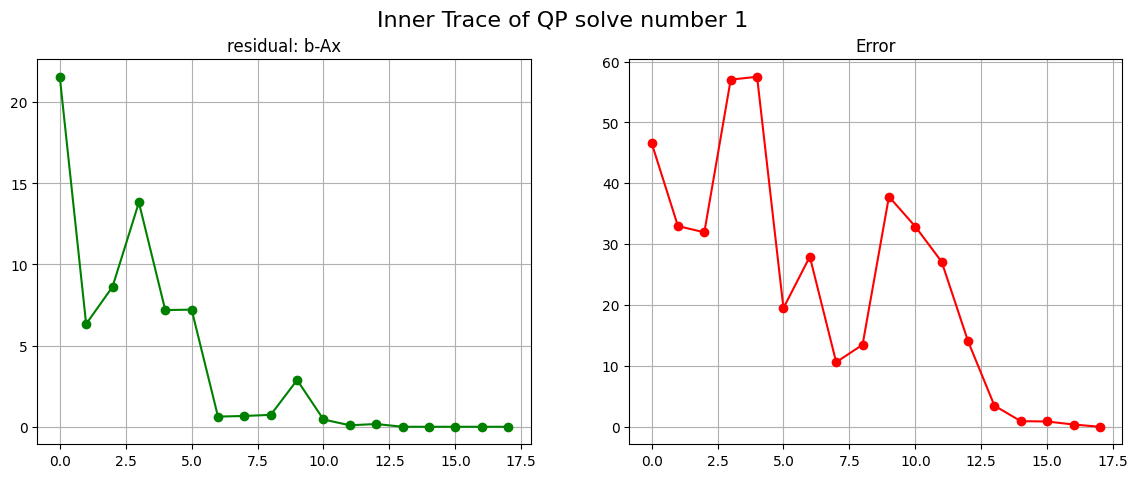

<Figure size 1000x500 with 0 Axes>

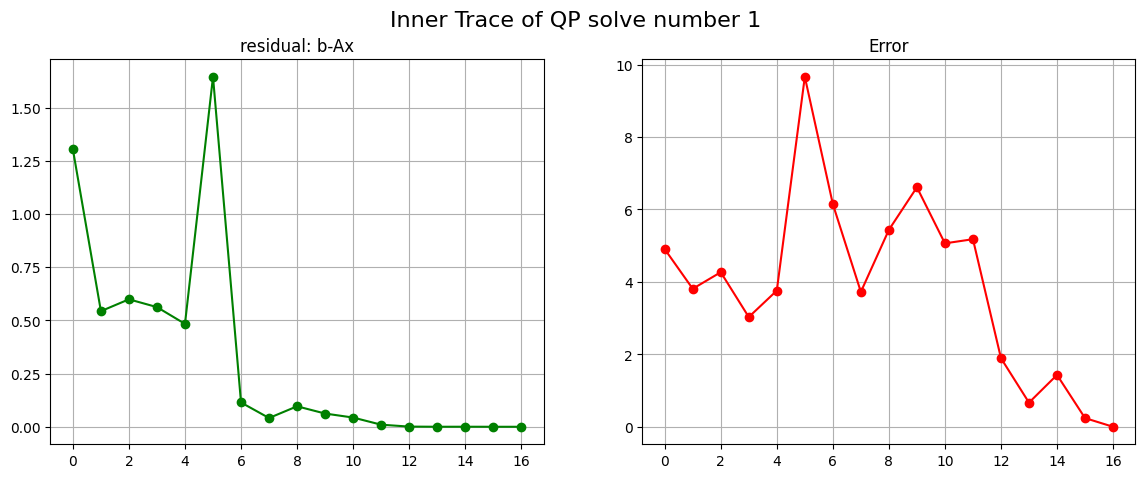

In [174]:
inner_traces= get_inner_traces_from_file(3)
plot_inner_trace(inner_traces,1)
inner_traces= get_inner_traces_from_file(4)
plot_inner_trace(inner_traces,1)

### Compare Final trajectory results

In [175]:
def get_results_from_file(id):
    df = pd.read_pickle(f'../data/{id}/results.plk')
    df = df.transpose()
    column_names = ['comp_time', 'J', 'Jx', 'Ju', 'error', 'E', 'exit_sqp', 'exit_soft', 'outer_iter', 'sqp_iter']
    df.columns = column_names
    df['Error in x']= df["error"].apply(lambda x: np.abs(x[0]))
    df['Error in y']= df["error"].apply(lambda x: np.abs(x[0]))
    df['Error Norm']=np.sqrt(df['Error in x']**2 + df['Error in y']**2 )
    df['Soft Constraint exit condition']=df['exit_soft'].map({0: 'No exit', 1: 'Convergence', 2: 'Max Iters', 3: 'Mu over limit for all soft constraints'})
    df['QP Solve exit condition']=df['exit_sqp'].map({0: 'No exit', 1: 'Convergence', 2: 'Max rho', 3: 'Max Iters'})
    df = df.rename(columns={'outer_iter': 'Soft constraint Loop iterations', 'sqp_iter': 'QP Solve Loop iterations'}).drop(columns=['exit_sqp', 'exit_soft'])
    return df

def plot_results(df):

    rows_to_compare = ['comp_time','J', 'E', 'Error Norm']
    df=df[rows_to_compare]
    results_1 = df[rows_to_compare].iloc[0]
    results_2 = df[rows_to_compare].iloc[1]
    fig, axs = plt.subplots(nrows=2, ncols=2, sharey=False)
    axs=axs.flatten()
    bar_width = 0.35
    for i, col in enumerate(df.columns):
        sns.barplot(x=['Trace 1', 'Trace 2'], y=[results_1[col], results_2[col]], ax=axs[i], palette= 'muted')
        # axs[i].bar([0, 1], [results_1[col], results_2[col]], bar_width, color=['blue', 'red'], edgecolor='black')
        axs[i].set_title(col)
        # axs[i].set_xticks([0, 1])
        # axs[i].set_xticklabels(['Trace 1', 'Trace 2'])
    fig.text(0.5, 0.04, 'Rows', ha='center')
    fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical')
    plt.suptitle('Final Trajectory Results')
    plt.tight_layout(rect=[0.02, 0.03, 1, 0.95])
plt.show()

/tmp/ipykernel_10364/2863206264.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Trace 1', 'Trace 2'], y=[results_1[col], results_2[col]], ax=axs[i], palette= 'muted')
/tmp/ipykernel_10364/2863206264.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Trace 1', 'Trace 2'], y=[results_1[col], results_2[col]], ax=axs[i], palette= 'muted')
/tmp/ipykernel_10364/2863206264.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Trace 1', 'Trace 2'], y=[results_1[col], results_2[col]], ax=axs[i], palette= 'muted')
/tmp/ipykernel_1036

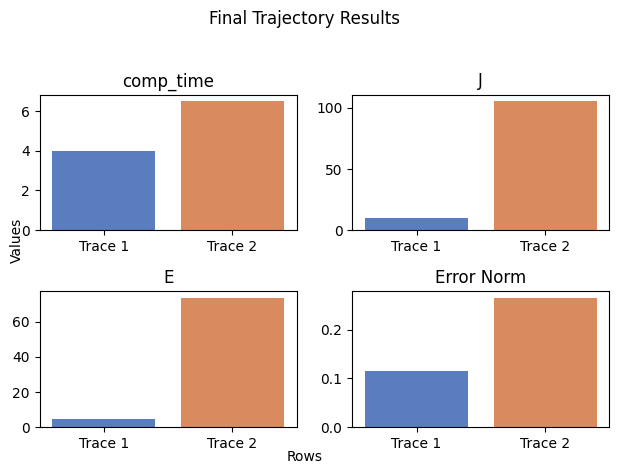

In [176]:
results_1=get_results_from_file(4)
results_2=get_results_from_file(3)
results=pd.concat((results_1,results_2)).reset_index().drop(columns='index')
plot_results(results)